In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import time
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import os
from sklearn.metrics import confusion_matrix

In [ ]:
SPECTRUM_IMAGES_CLASSES_TRAIN = '../GeneratedData/urban-sound-classification/train/Train/'
SPECTRUM_IMAGES_CLASSES_TEST = ''
INPUT_RESOLUTION = 224

In [2]:
SPECTRUM_IMAGES_CLASSES_TRAIN = '../GeneratedData/Cats-Vs-Dogs/'
SPECTRUM_IMAGES_CLASSES_TEST = ''
INPUT_RESOLUTION = 224

In [ ]:
SPECTRUM_IMAGES_CLASSES_TRAIN = '../GeneratedData/audio-cats-and-dogs/cats_dogs/train/'
SPECTRUM_IMAGES_CLASSES_TEST = '../GeneratedData/audio-cats-and-dogs/cats_dogs/test/'
INPUT_RESOLUTION = 224

In [17]:
transform = transforms.Compose(
    [transforms.Resize(INPUT_RESOLUTION),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset=[]
testset=[]
NoTestSet=False
full_dataset=None
if len(SPECTRUM_IMAGES_CLASSES_TEST)==0:
    print("Using one data set and sperating them with an 80%/20% split")
    full_dataset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TRAIN, transform=transform)
    full_DataLoader = torch.utils.data.DataLoader(full_dataset, batch_size=4, shuffle=True, num_workers=2)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    NoTestSet=True
else:
    print("Using pre-seperated test and training data sets!")
    trainset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TRAIN, transform=transform)
    testset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TEST, transform=transform)
    

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=None
if(NoTestSet):
    classes = full_DataLoader.dataset.classes
else:
    classes = trainloader.dataset.classes

print(classes)


Using one data set and sperating them with an 80%/20% split
['Cats', 'Dogs']


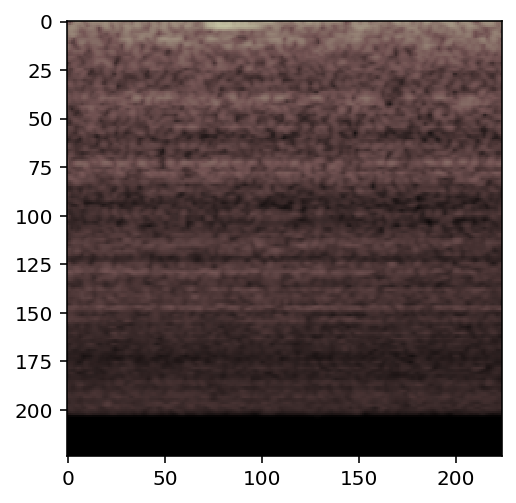

Cats


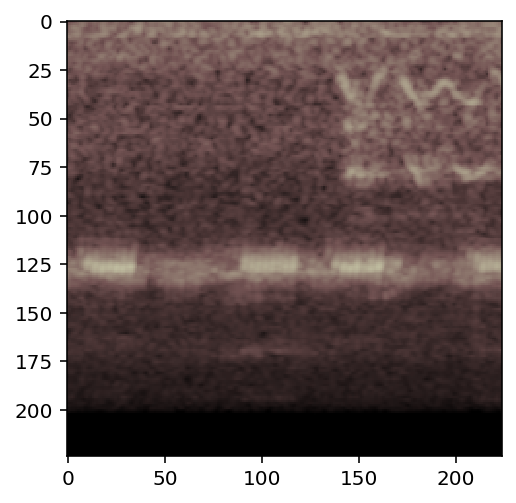

Dogs


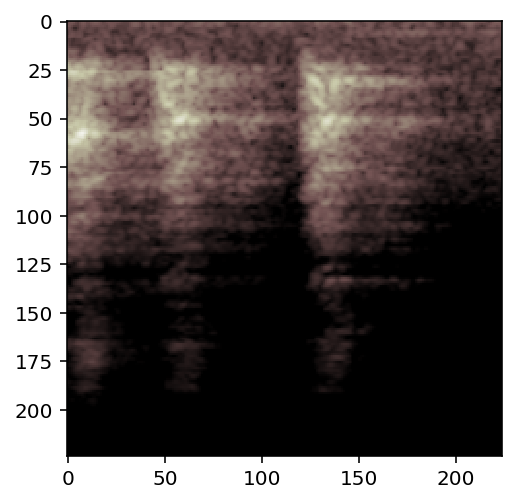

Dogs


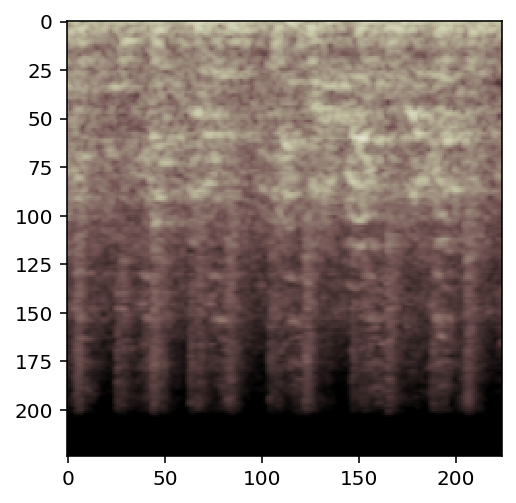

Dogs


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
for i in range(trainloader.batch_size):
    imshow(images[i])
    print(classes[labels[i]])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)

In [5]:
ModelData = torch.load('../Models/MainModelUrban.pth',map_location='cpu')
model.load_state_dict(ModelData['model'])
# IncompatibleKeys(missing_keys=[], unexpected_keys=[]) Means it was succesfull

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, len(classes)) # assuming that the fc7 layer has 512 neurons, otherwise change it 

In [7]:
print(device)
if device.type=='cuda':
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

cpu


In [ ]:
for i in range(5):  # loop over the dataset multiple times
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, data in enumerate(trainloader, 0):
        #print("Running Batches",i)
        # get the inputs
        inputs, labels = data
        if device.type=='cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        if(i%200==0):
            print('At data point',i,time.time()-t0)
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss+=loss.item()
        #break;
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            if device.type=='cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                print('Testing at data point',i,time.time()-t0)
    
    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done

print('Finished Training')


Starting epoch: 12
At data point 0 0.09117722511291504
At data point 200 73.12541007995605
About to test the performance on the test set.
Testing at data point 0 129.1151020526886
Testing at data point 50 133.1793601512909
Testing at data point 100 137.23668599128723


In [ ]:
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':INPUT_RESOLUTION,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

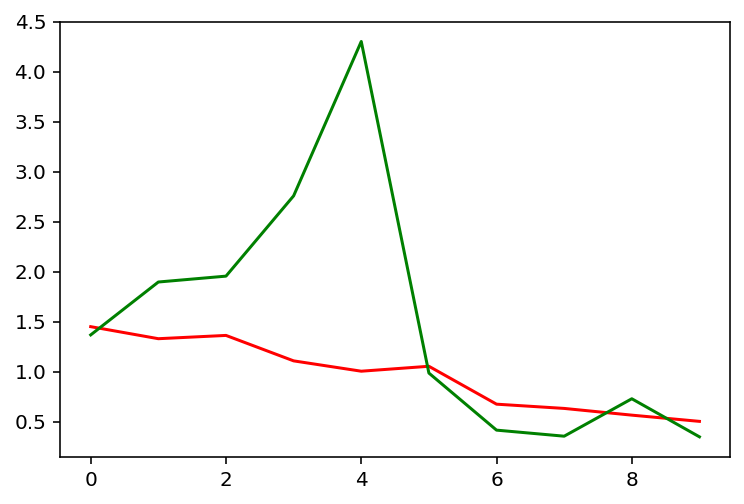

In [15]:
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.show()

In [10]:
dataiter = iter(testloader)
model.eval()
for j in range (2):
    images, labels = dataiter.next()
    if device == 'cuda':
        images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
        imshow(images[i])
        print('GroundTruth: ',classes[labels[i]])
        print('Predicted: ',  classes[predicted[i]])


NameError: name 'imshow' is not defined

In [16]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            if(testloader.batch_size>1):
                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[[669 128]
 [ 21 618]]
Accuracy of  Cats : 83 %
Accuracy of  Dogs : 96 %


In [19]:
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co